In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import  Activation, BatchNormalization, Add
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.regularizers import l2
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
seed=42

In [ ]:
df=pd.read_csv('features_flight_heli.csv')
df.dropna(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6865 entries, 0 to 6864
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fname        6865 non-null   object 
 1   alt_max      6865 non-null   float64
 2   vert_acc     6865 non-null   float64
 3   horiz_speed  6865 non-null   float64
 4   dist         6865 non-null   float64
 5   is_maneuver  6865 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 321.9+ KB


In [ ]:
df.drop(['fname'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6865 entries, 0 to 6864
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alt_max      6865 non-null   float64
 1   vert_acc     6865 non-null   float64
 2   horiz_speed  6865 non-null   float64
 3   dist         6865 non-null   float64
 4   is_maneuver  6865 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 268.3 KB


In [ ]:
Y = df['is_maneuver']
X = df.drop(['is_maneuver'], axis=1)

print(X.shape)
print(Y.shape)

(6865, 4)
(6865,)


In [ ]:
df['is_maneuver'].value_counts()

1    5104
0    1761
Name: is_maneuver, dtype: int64

In [ ]:
class_counts = df['is_maneuver'].value_counts()
target_count = class_counts.min()
df = df.groupby('is_maneuver').apply(lambda group: group.sample(target_count))

print("Balanced class distribution:")
print(df['is_maneuver'].value_counts())

Balanced class distribution:
0    1761
1    1761
Name: is_maneuver, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=seed)

In [ ]:
X_train = np.array(X_train)
X_test=np.array(X_test)

In [ ]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [ ]:
inputs = Input(shape=(X_train.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

residual = x

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

residual = Dense(32, activation='relu')(residual)
x = Add()([x, residual])
x = Activation('relu')(x)

outputs = Dense(1, activation='sigmoid')(x)


model10 = Model(inputs=inputs, outputs=outputs)


optimizer = Adam(learning_rate=0.001)
model10.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [ ]:
history10= model10.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[lr_reduction, early_stopping])

Epoch 1/100
138/138 [==============================] - 4s 10ms/step - loss: 1.2367 - accuracy: 0.7756 - val_loss: 1.1520 - val_accuracy: 0.7316 - lr: 0.0010
Epoch 2/100
138/138 [==============================] - 1s 10ms/step - loss: 1.0654 - accuracy: 0.8313 - val_loss: 1.0617 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 3/100
138/138 [==============================] - 2s 12ms/step - loss: 1.0356 - accuracy: 0.8404 - val_loss: 1.0109 - val_accuracy: 0.8326 - lr: 0.0010
Epoch 4/100
138/138 [==============================] - 1s 10ms/step - loss: 0.9764 - accuracy: 0.8500 - val_loss: 0.9534 - val_accuracy: 0.8617 - lr: 0.0010
Epoch 5/100
138/138 [==============================] - 1s 8ms/step - loss: 0.9303 - accuracy: 0.8559 - val_loss: 0.9042 - val_accuracy: 0.8608 - lr: 0.0010
Epoch 6/100
138/138 [==============================] - 1s 8ms/step - loss: 0.8880 - accuracy: 0.8625 - val_loss: 0.8717 - val_accuracy: 0.8590 - lr: 0.0010
Epoch 7/100
138/138 [==============================] - 1s 8m

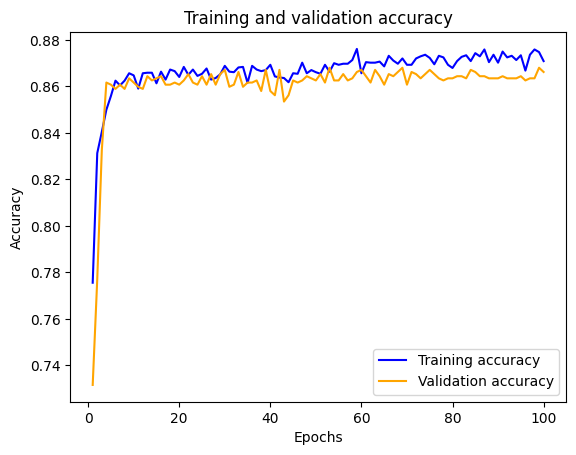

0.8761666417121887

In [ ]:
acc = history10.history['accuracy']
val_acc = history10.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'blue', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(acc)

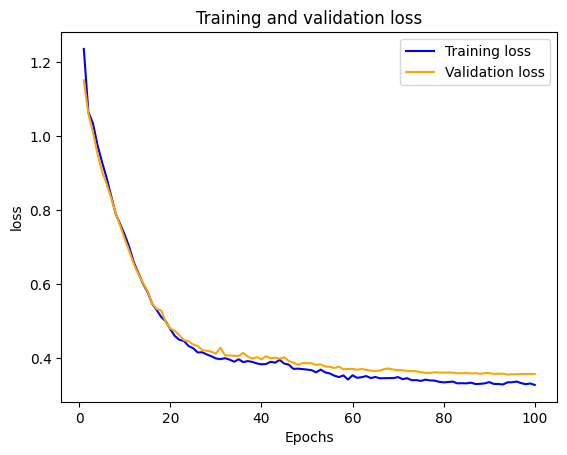

1.2367192506790161

In [ ]:
loss = history10.history['loss']
val_loss = history10.history['val_loss']
epochs = range(1, len(loss) + 1)


plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


np.max(loss)

In [ ]:
y_pred = model10.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)


43/43 [==============================] - 0s 2ms/step


In [ ]:
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)

Test Precision: 0.8957345971563981
Test Recall: 0.9255631733594515
Test F1 Score: 0.9104046242774565


In [ ]:
fpr, tpr, threshold= roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)
roc_metrics = pd.DataFrame(fpr, columns=['fpr'])
roc_metrics['tpr'] = tpr

roc_metrics.to_csv('./metrics/roc_xcp.csv')

AUC: 0.8985258436470486


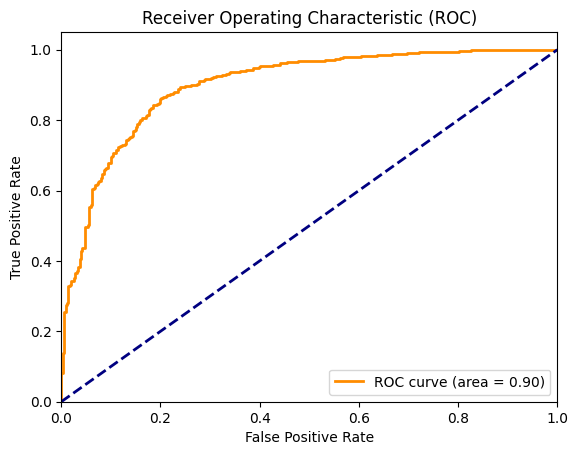

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
metrics = pd.DataFrame(history10.history)

In [ ]:
if not os.path.exists('./metrics'):
    os.makedirs('./metrics')


In [ ]:

metrics.to_csv('./metrics/lda.csv', index=False)